#### Aquí encontrarás todo lo que necesitas saber: https://www.kaggle.com/competitions/desafio-de-prediccion-de-precios-de-portatiles

## Librerias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import bootcampviztools as bt
import statsmodels.api as sm
import warnings
import sklearn
import os
import cv2


from matplotlib import style
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.metrics import classification_report, ConfusionMatrixDisplay,  mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, silhouette_score, silhouette_samples, mutual_info_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, scale
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.utils import resample
from scipy import stats
from scipy.stats import mannwhitneyu


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor


warnings.filterwarnings('ignore')
style.use('ggplot') or plt.style.use('ggplot')

## Data

In [2]:
### Para que funcione necesitas bajarte los archivos de datos de Kaggle 
pcs = pd.read_csv("./data/train.csv")

## Data exploration

In [3]:
pcs.head()

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,268,1002,Dell,Inspiron 5567,Notebook,15.6,1366x768,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,AMD Radeon R7 M445,Windows 10,2.36kg,749.00
1,347,867,Asus,X541NA (N4200/4GB/1TB/W10),Notebook,15.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4GB,1TB HDD,Intel HD Graphics 505,Windows 10,2kg,449.00
2,353,966,Toshiba,Portege Z30-C-1CW,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.2kg,1460.00
3,578,767,Dell,Alienware 17,Gaming,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,4.42kg,2868.99
4,42,1241,Dell,Latitude E7270,Ultrabook,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.26kg,1713.37


In [4]:
pcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                912 non-null    int64  
 1   laptop_ID         912 non-null    int64  
 2   Company           912 non-null    object 
 3   Product           912 non-null    object 
 4   TypeName          912 non-null    object 
 5   Inches            912 non-null    float64
 6   ScreenResolution  912 non-null    object 
 7   Cpu               912 non-null    object 
 8   Ram               912 non-null    object 
 9   Memory            912 non-null    object 
 10  Gpu               912 non-null    object 
 11  OpSys             912 non-null    object 
 12  Weight            912 non-null    object 
 13  Price_euros       912 non-null    float64
dtypes: float64(2), int64(2), object(10)
memory usage: 99.9+ KB


In [5]:
# No hay nulos, bien!
# numéricas hay apenas 4 (las 2 de IF, las inches y el precio, que es el target)
# Tenemos una gran parte de variables categóricas que habrá que procesar y transformar en numéricas

In [6]:
pcs.describe()

,id,laptop_ID,Inches,Price_euros
count,912.000000,912.000000,912.000000,912.000000
mean,645.091009,666.192982,15.011404,1108.122873
std,380.313813,384.873846,1.411744,714.597741
min,0.000000,1.000000,10.100000,174.000000
25%,319.750000,330.500000,14.000000,589.000000
50%,636.500000,673.500000,15.600000,949.000000
75%,980.250000,998.500000,15.600000,1458.500000
max,1302.000000,1320.000000,18.400000,6099.000000


In [7]:
target = "Price_euros"

In [8]:
pcs["Company"].value_counts()

Company
Lenovo       208
Dell         207
HP           189
Asus         108
Acer          75
Toshiba       37
MSI           34
Apple         17
Mediacom       7
Razer          6
Samsung        6
Fujitsu        3
Microsoft      3
Vero           3
Xiaomi         3
Google         2
Chuwi          2
LG             1
Huawei         1
Name: count, dtype: int64

In [9]:
pcs["Product"].value_counts()

Product
Inspiron 3567                                21
XPS 13                                       20
250 G6                                       19
Vostro 3568                                  16
Inspiron 5570                                11
                                             ..
Elitebook Folio                               1
Q304UA-BHI5T11 (i5-7200U/6GB/1TB/FHD/W10)     1
ThinkPad T470p                                1
V310-15IKB (i5-7200U/4GB/1TB/No               1
Portege Z30-C-16H                             1
Name: count, Length: 475, dtype: int64

In [10]:
pcs["Product"].value_counts().unique()

array([21, 20, 19, 16, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1],
      dtype=int64)

In [11]:
pcs["TypeName"].value_counts()

TypeName
Notebook              522
Gaming                138
Ultrabook             135
2 in 1 Convertible     85
Workstation            18
Netbook                14
Name: count, dtype: int64

In [12]:
pcs["Inches"].value_counts()

Inches
15.6    474
14.0    143
13.3    111
17.3    108
12.5     28
11.6     21
12.0      6
10.1      4
13.9      4
15.4      3
15.0      3
13.5      3
12.3      2
13.0      1
18.4      1
Name: count, dtype: int64

<Axes: >

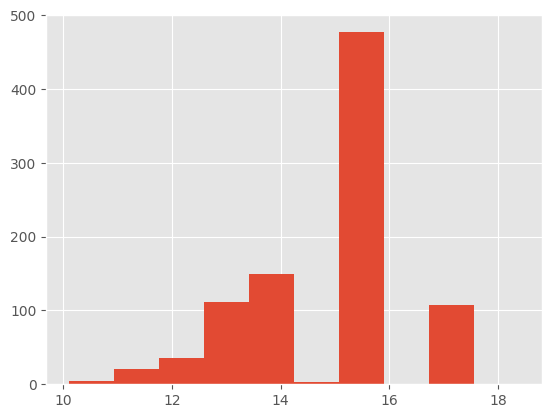

In [13]:
pcs["Inches"].hist()

In [14]:
pcs["ScreenResolution"].value_counts()

ScreenResolution
Full HD 1920x1080                                346
1366x768                                         208
IPS Panel Full HD 1920x1080                      163
IPS Panel Full HD / Touchscreen 1920x1080         37
Full HD / Touchscreen 1920x1080                   32
Touchscreen 1366x768                              15
1600x900                                          11
IPS Panel 4K Ultra HD 3840x2160                   10
4K Ultra HD / Touchscreen 3840x2160                8
Quad HD+ / Touchscreen 3200x1800                   8
IPS Panel 4K Ultra HD / Touchscreen 3840x2160      8
IPS Panel Retina Display 2304x1440                 6
IPS Panel Retina Display 2560x1600                 5
IPS Panel 1366x768                                 5
4K Ultra HD 3840x2160                              5
IPS Panel Touchscreen 1920x1200                    4
Touchscreen 2560x1440                              4
IPS Panel Quad HD+ / Touchscreen 3200x1800         4
IPS Panel Touchscreen 2560x14

In [15]:
pcs["Cpu"].value_counts()

Cpu
Intel Core i5 7200U 2.5GHz     142
Intel Core i7 7700HQ 2.8GHz    102
Intel Core i7 7500U 2.7GHz      88
Intel Core i5 8250U 1.6GHz      54
Intel Core i5 6200U 2.3GHz      51
                              ... 
Intel Core i7 7660U 2.5GHz       1
AMD E-Series E2-9000 2.2GHz      1
Intel Core i3 6006U 2.2GHz       1
Intel Core i7 2.8GHz             1
AMD E-Series 9000 2.2GHz         1
Name: count, Length: 104, dtype: int64

In [16]:
pcs["Ram"].value_counts()

Ram
8GB     434
4GB     274
16GB    125
6GB      32
2GB      16
12GB     15
32GB     14
24GB      2
Name: count, dtype: int64

In [17]:
pcs["Memory"].value_counts()

Memory
256GB SSD                        293
1TB HDD                          150
500GB HDD                        100
512GB SSD                         75
128GB SSD +  1TB HDD              61
128GB SSD                         56
256GB SSD +  1TB HDD              52
32GB Flash Storage                27
64GB Flash Storage                11
2TB HDD                           11
512GB SSD +  1TB HDD              10
1TB SSD                            9
1.0TB Hybrid                       7
256GB Flash Storage                7
32GB SSD                           5
180GB SSD                          5
256GB SSD +  2TB HDD               4
16GB Flash Storage                 4
16GB SSD                           3
256GB SSD +  500GB HDD             2
1TB SSD +  1TB HDD                 2
128GB Flash Storage                2
512GB SSD +  2TB HDD               2
512GB Flash Storage                2
1.0TB HDD                          1
32GB HDD                           1
128GB SSD +  2TB HDD           

In [18]:
pcs["Gpu"].value_counts()

Gpu
Intel HD Graphics 620      199
Intel HD Graphics 520      138
Intel UHD Graphics 620      45
Nvidia GeForce GTX 1050     43
Nvidia GeForce GTX 1060     31
                          ... 
Nvidia GeForce 920MX         1
Intel HD Graphics 620        1
AMD Radeon R7 M365X          1
Nvidia Quadro M2200M         1
Nvidia Quadro M520M          1
Name: count, Length: 91, dtype: int64

In [19]:
pcs["OpSys"].value_counts()

OpSys
Windows 10      746
Linux            47
No OS            44
Windows 7        32
Chrome OS        20
macOS            11
Mac OS X          6
Windows 10 S      4
Android           2
Name: count, dtype: int64

In [20]:
pcs["Weight"].value_counts()

Weight
2.2kg     86
2.1kg     40
2.3kg     35
2.4kg     31
2kg       30
          ..
4.0kg      1
0.98kg     1
3.6kg      1
2.99kg     1
1.79kg     1
Name: count, Length: 158, dtype: int64

## Data processing

In [21]:
# Separación train y test

In [22]:
pcs = pcs.drop("laptop_ID", axis = 1)
pcs = pcs.drop("Product", axis = 1)

X = pcs.drop("Price_euros", axis = 1)
y = pcs["Price_euros"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [23]:
len(X_train)

729

In [24]:
len(X_test)

183

In [25]:
# Mini EDA
pcs_eda = pd.concat([X_train, y_train], axis=1)

In [26]:
target = "Price_euros"
var_categ = []
var_num = [] 

In [27]:
# A ver la distribución de las numéricas

# Pero primero tenemos que hacer una ligera transformación a la columna Weight:
pcs_eda['Weight'] = pcs_eda['Weight'].apply(lambda x: int(x.replace('kg', '').replace('.', '')))
var_num.append("Weight")


In [28]:
# Y lo mismo con la columna Ram, aunque ésta bien podría ser categórica:
pcs_eda['Ram'] = pcs_eda['Ram'].apply(lambda x: int(x.replace('GB', '')))
var_num.append("Ram")

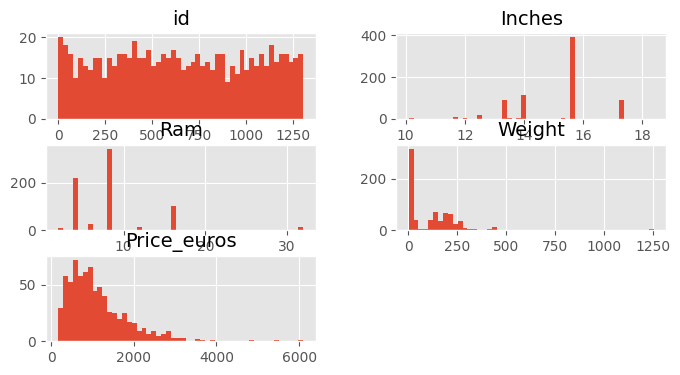

In [29]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

pcs_eda.hist(bins=50, figsize=(8, 4))
plt.show()

# inches tb parece ser interesante y me la quedo. A id obviamente no le hago caso, ni a Price que es el target
var_num.append("Inches")

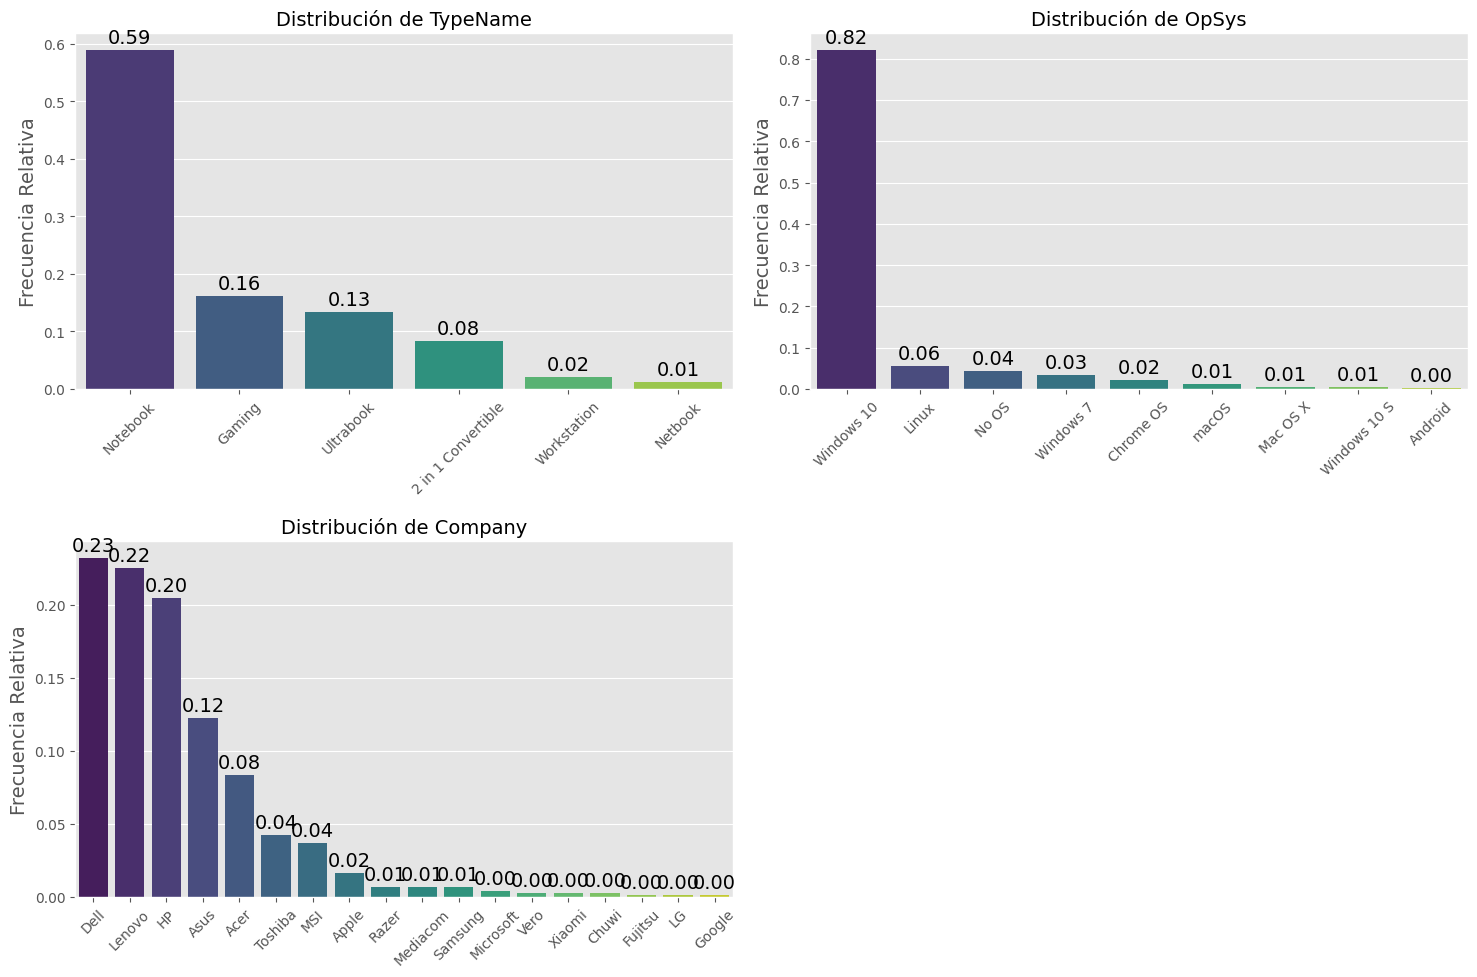

In [30]:
# Y la frecuencia de las categóricas
bt.pinta_distribucion_categoricas(X_train, ['TypeName',
 'OpSys',
 'Company'], relativa= True, mostrar_valores= True)

# Algunas necesitan ser procesadas, mucha cardinalidad, como Company 

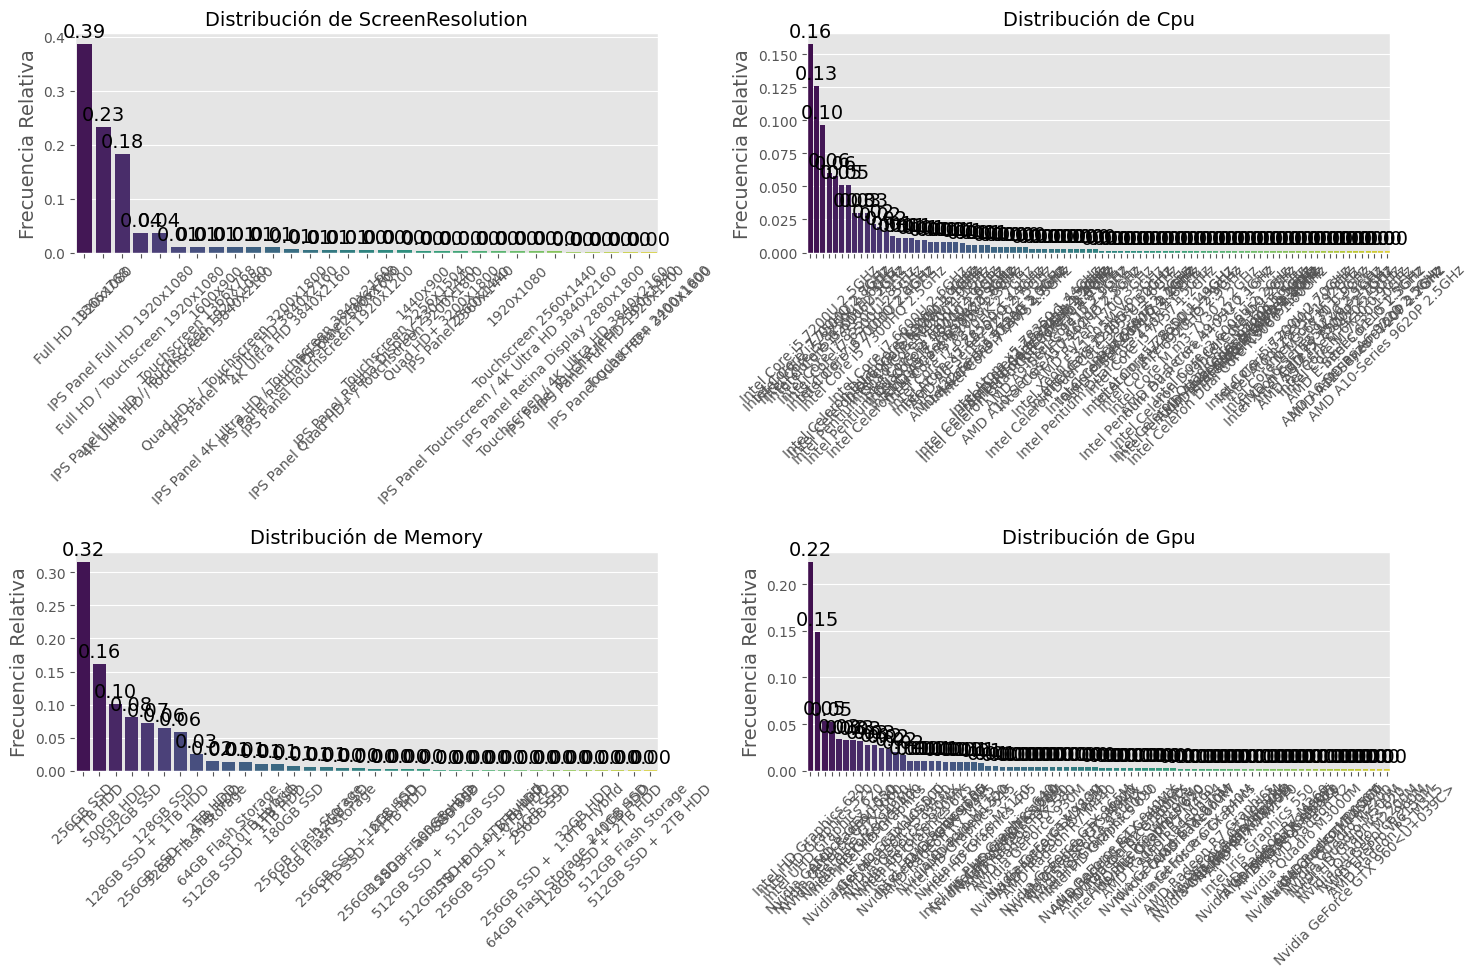

In [31]:
# Estas otras hay que procesarlas aún más

bt.pinta_distribucion_categoricas(X_train, [
 'ScreenResolution',
 'Cpu',
 'Memory',
 'Gpu'], relativa= True, mostrar_valores= True)

In [32]:
# Vamos primero al bivaruante de las categóricas, una por una contra el target

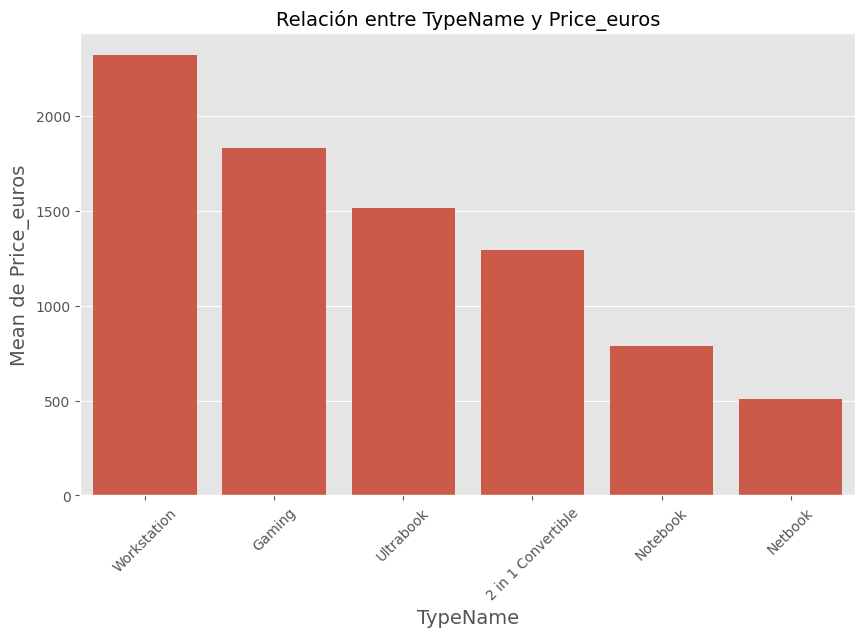

In [33]:
bt.plot_categorical_numerical_relationship(pcs_eda, categorical_col= "TypeName", numerical_col="Price_euros")
# a primera vista esta variable nos interesa
var_categ.append("TypeName")

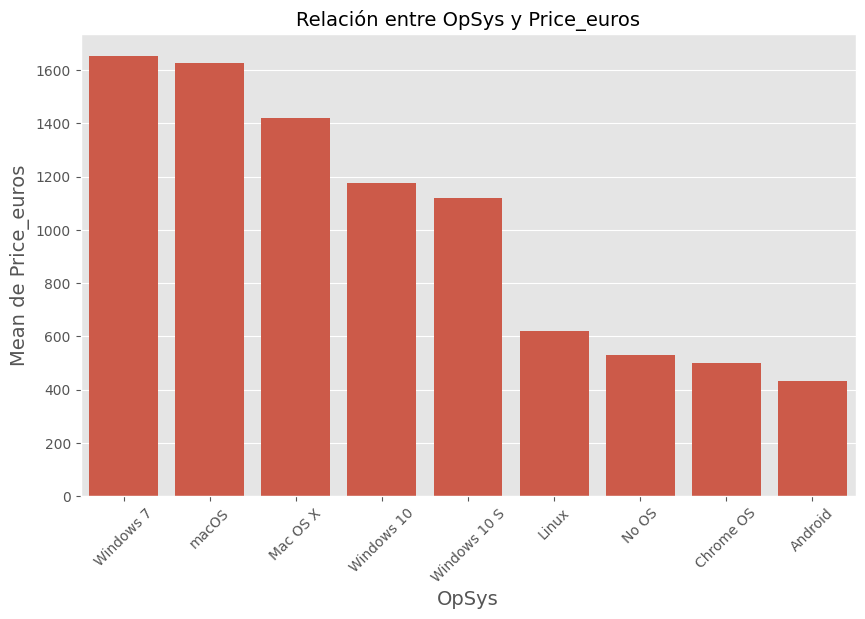

In [34]:
bt.plot_categorical_numerical_relationship(pcs_eda, categorical_col= "OpSys", numerical_col="Price_euros")
# a primera vista esta variable nos interesa
var_categ.append("OpSys")

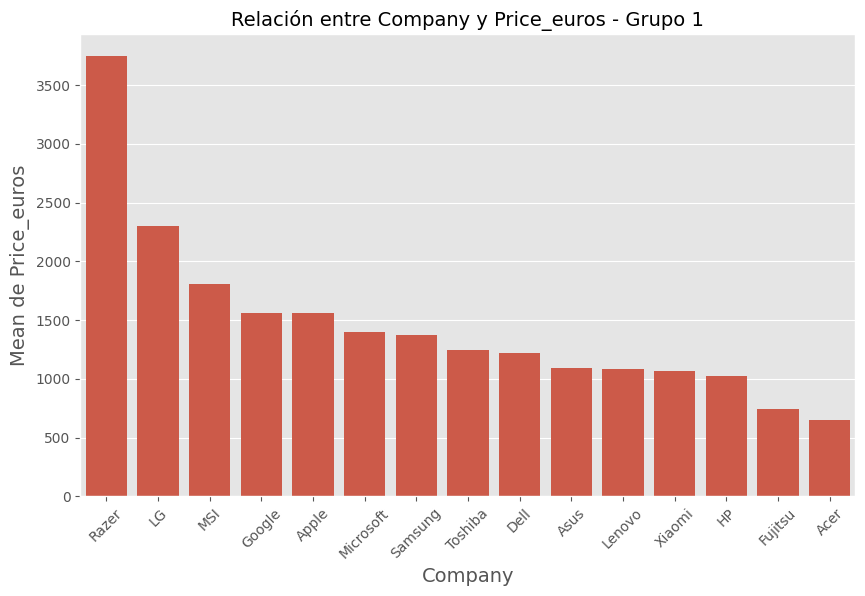

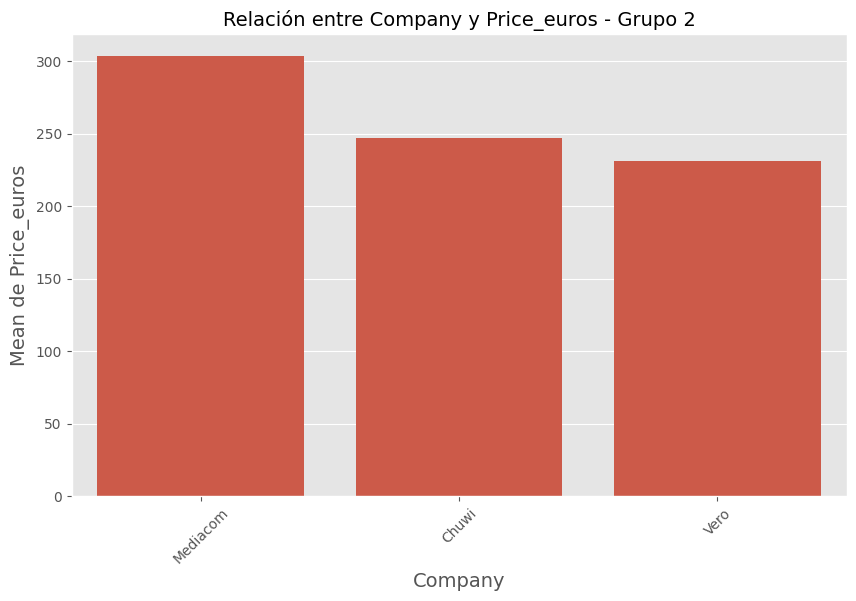

In [35]:
bt.plot_categorical_numerical_relationship(pcs_eda, categorical_col= "Company", numerical_col="Price_euros")
# a primera vista esta variable nos interesa, aunque es más plana que las otras. Al final me las he quedado todas
var_categ.append("Company")

In [36]:
# Analicemos ahora target vs las Numéricas

In [37]:
corr_matrix = pcs_eda.corr(numeric_only= True)
corr_matrix["Price_euros"].sort_values(ascending = False)

# el id evidentemente no tiene ninguna influencia en el precio y RAM la tomo como categ.

Price_euros    1.000000
Ram            0.754267
Weight         0.236210
Inches         0.106196
id            -0.012153
Name: Price_euros, dtype: float64

In [38]:
columnas = corr_matrix["Price_euros"][corr_matrix["Price_euros"] > 0.07].index.to_list()

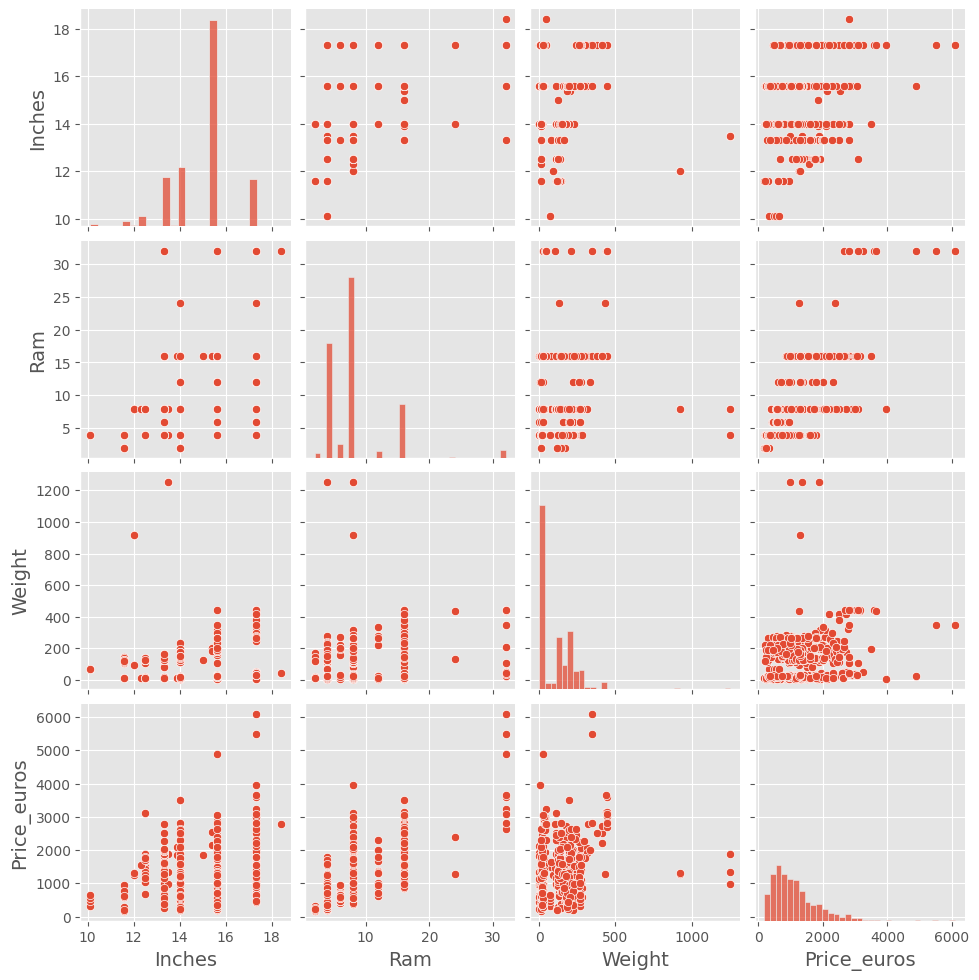

In [39]:
sns.pairplot(pcs_eda[columnas]);

In [40]:
# Y  las que había que procesar ('ScreenResolution', 'Cpu', 'Memory', 'Gpu'), que las vamos a desdoblar

In [45]:
# ScreenResolution en 2 partes. la numeral y la categórica

def extract_resolution(s):
    match = re.search(r'(\d{3,4})x(\d{3,4})', s)
    if match:
        return int(match.group(1)) * int(match.group(2))
    else:
        return None
    
pcs_eda['SCR_resol'] = pcs_eda['ScreenResolution'].apply(extract_resolution)

# ADEMÁS DE CORREGIR, AÑADIR ESTA A NUMERAL Y LAS SIGUIENTES A CATEGÓRICAS, DE PANTALLA
# Y HACER LO MISMO CON LAS OTRAS FEATURES DE ESTE TIPO

# DESPUES CONTRASTAR LAS CATEGÓRICAS CONTRA TARGET, COMO LAS ANTERIORES

# LUEGO SUMARLAS NUMÉRICAS A LA MATRIZ DE CORRELACIÓN

# MIRAR TAMBIÉN ESE HISTOGRAMA QUE NUNCA HAGO...CREO QUE PARA LAS CATEGÓRICAS CON TARGET NUM

NameError: name 're' is not defined

In [43]:
for label in ['Touchscreen', 'FullHD', 'Retina', 'HD+', '4K', 'IPS Panel']:
    pcs_eda[f'SCR_{label}'] = pcs_eda['ScreenResolution'].str.contains(label).astype(int)


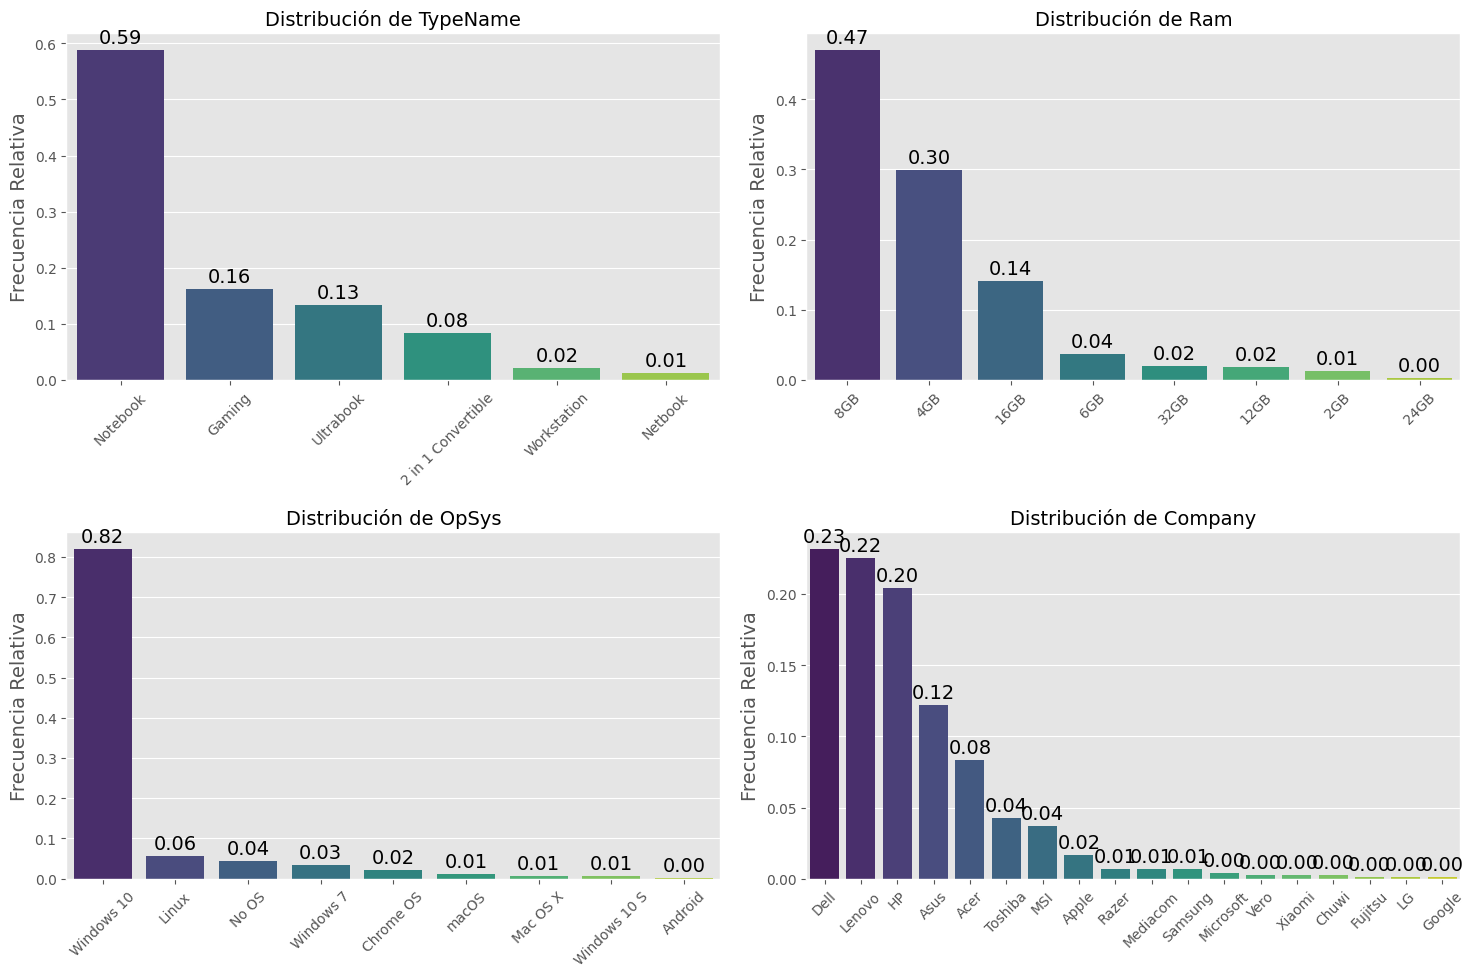

In [ ]:
# Y la frecuencia de las categóricas
bt.pinta_distribucion_categoricas(X_train, ['TypeName',
 'OpSys',
 'Company'], relativa= True, mostrar_valores= True)

# Algunas necesitan ser procesadas, mucha cardinalidad, como Company 

NameError: name 're' is not defined

In [ ]:
Le tengo que aplicar a test y todo:
pcs_eda['Weight'] = pcs_eda['Weight'].apply(lambda x: int(x.replace('kg', '').replace('.', '')))
pcs_eda['Ram'] = pcs_eda['Ram'].apply(lambda x: int(x.replace('GB', '')))

lo de las marcas


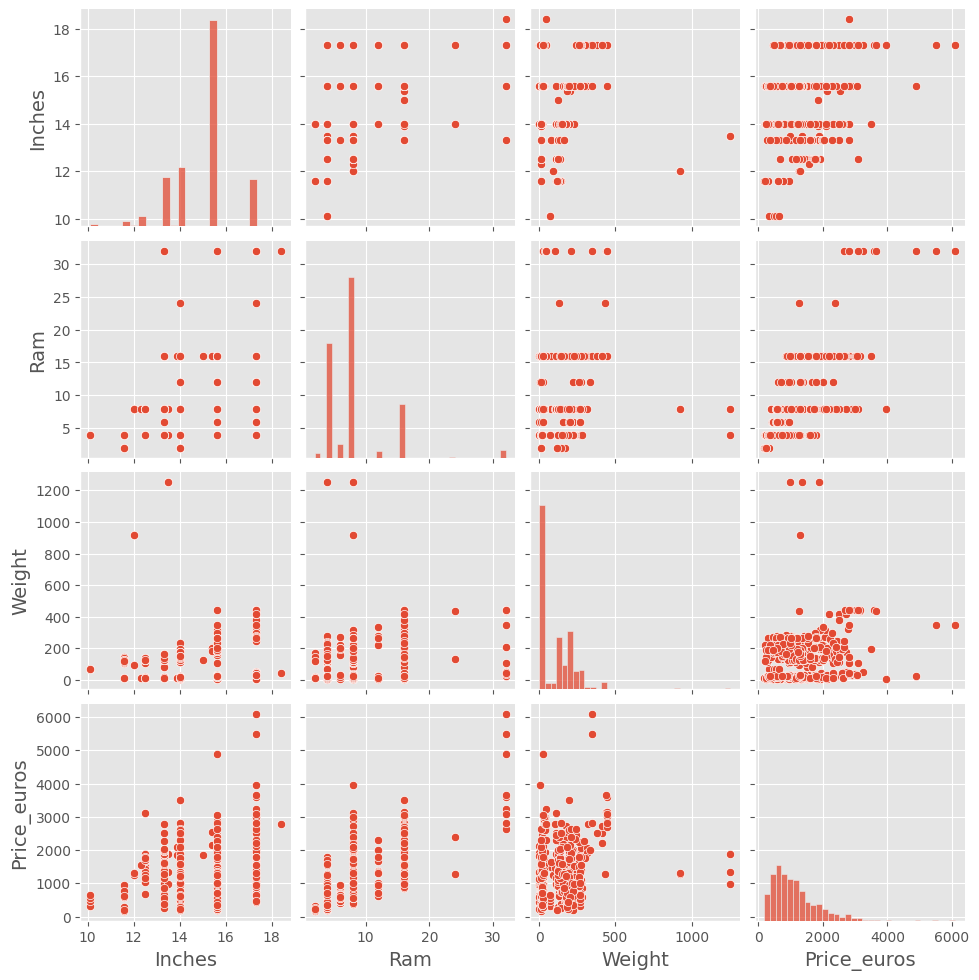

In [ ]:
sns.pairplot(pcs_eda[columnas]);

In [ ]:
# Tratamiento de variables categóricas

In [ ]:
#Cosas que hice en el EDA y hay que hacer a train y test:
#pcs_eda['Ram'] = pcs_eda['Ram'].apply(lambda x: int(x.replace('GB', '')))

In [ ]:
# Ordinales

In [ ]:
categories = [["ISLAND","NEAR OCEAN","NEAR BAY","<1H OCEAN","INLAND"]] 
ordinal_encoder = OrdinalEncoder(categories= categories) 
pcs_eda["ordinal_ocean"] = ordinal_encoder.fit_transform(pcs_eda[["ocean_proximity"]])

NameError: name 'OrdinalEncoder' is not defined

In [ ]:
# No ordinales

In [ ]:
# Tratamiento de Company
marcas_ppales = pcs['Company'].value_counts().sort_values(ascending=False) / pcs['Company'].count()
top_10_companies = marcas_ppales[marcas_ppales >= 0.01].index.tolist()
otras_marcas = [company for company in pcs['Company'].unique() if company not in top_10_companies]
pcs['Company'] = pcs['Company'].replace(otras_marcas, "Otra")

In [ ]:
pcs["Company"].value_counts(True)

Company
Lenovo     0.228070
Dell       0.226974
HP         0.207237
Asus       0.118421
Acer       0.082237
Toshiba    0.040570
Otra       0.040570
MSI        0.037281
Apple      0.018640
Name: proportion, dtype: float64

In [ ]:
pcs = pd.get_dummies(pcs, columns=['Company'], prefix='Marca', prefix_sep='_', drop_first=True)

In [ ]:
# Ordinales

In [ ]:
ordinal_encoder = OrdinalEncoder()
X_traint["ordinal_ocean"] = ordinal_encoder.fit_transform(train_set[["ocean_proximity"]])
# ADAPTAR

NameError: name 'OrdinalEncoder' is not defined

In [ ]:
# Tratamiento de variables numéricas

-----------------------------------------------------------------------------------------------------------------

## Pasos que si o si debéis realizar para poder participar en la competición:

### 1. Definir X e y

### 2. Dividir X_train, X_test, y_train, y_test

### 3. Crear y entrenar el modelo


### 4. Sacar métricas, valorar el modelo 

Recuerda que en la competición se va a evaluar con la métrica de MAE.

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir con el dataset de predicción 

Definición de **modelo que está listo**. 

Tras hacer suficientes pruebas, analizar los datos, hacer feature engineering, probar diferentes modelos con diferentes parámetros, es con este con el que observo mejores métricas y menos overfitting. ¡Cuidado con el overfitting aquí! Si vuestro modelo aprende muy bien de estos datos pero hay overfitting cuando le pasemos los datos desconocidos de `test.csv` nos arriesgamos a que digamos, no salga lo esperado.

### 1. Entrena dicho modelo con TODOS tus datos de train, esto es con `train.csv` al completo.


**CON LAS TRANSFORMACIONES QUE LE HAYAS REALIZADO A `X` INCLUÍDAS.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 2. Carga los datos de `test.csv` para predecir.

**¿Por qué puede dar error?** 

IMPORTANTE: APLICAR A ESTOS DATOS LO MISMO QUE HAYÁIS APLICADO A LOS DATOS DE ENTRENAMIENTO

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO BORRAR FILAS, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER 391 FILAS, SI O SI

**Entonces, si al cargar los datos de train usé `index_col=0` para que utilizara la primera columna del conjunto de datos como índice, ¿tendré que hacerlo también para el conjunto `test.csv`?**

In [ ]:
# ¿Qué opináis?
# Sí

![](https://www.tierraljelechu.com/web/img/wiki_up/1.996-SorpresaDto.-1-Red.jpg)

### 3. AHORA puedo hacer la predicción que será lo que subirás a Kaggle. 

**¿Qué es lo que subirás a Kaggle?**

In [ ]:
predictions = model.predict(X_pred)
predictions

NameError: name 'model' is not defined

**¡PERO! Para subir a Kaggle la predicción, ésta tendrá que tener una forma específica y no valdrá otra.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [ ]:
sample = pd.read_csv("Dataset/sample_submission.csv") # Esta es mi ruta del archivo, la vuestra puede ser otra

In [ ]:
sample.head()

In [ ]:
sample.shape

### 4. Mete tus predicciones en un dataframe. 

En este caso, la **MISMA** forma que `sample_submission.csv`. 

### 5. Pásale el CHEQUEATOR para comprobar que efectivamente está listo para subir a Kaggle.

In [ ]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("")


In [ ]:
chequeator(submission) # submission es el nombre que le habríamos puesto a nuestro .csv con los valores que me salieron en la predicción

You're ready to submit!
